In [35]:
import tensorflow as tf
import numpy as np

from tensorflow.python.layers import core as layers_core
from prepare_data import get_decoder_data_int_sequences

from matplotlib import pyplot as plt
from tensor2tensor.layers.common_attention import add_timing_signal_nd #currently not in use


In [36]:
tf.reset_default_graph()

In [37]:
### Outline

# 1. Encoder
# 2. Decoder
# 3. Optimization and training


# What is bucketing?





In [38]:
import numpy as np
import math
import cv2

def get_max_shape(images):

	max_height = 0
	max_width = 0
	print("Getting max shape")

	for image in images:

		if image.shape[0] > max_height:
			max_height = image.shape[0]

		if image.shape[1] > max_width:
			max_width = image.shape[1]


	return [max_height, max_width]


def normalize_images(images):

	images = images.astype(np.float32)
	images = np.multiply(images, 1.0 / 255.0)

	return images

def down_sample(images, factor): 
	target_h = int(math.floor(float(images[0].shape[0]) * factor))
	target_w = int(math.floor(float(images[0].shape[1]) * factor))
	num_images = len(images)
	down_sampled_images = np.ones((num_images, target_h, target_w)) * 255

	for idx, image in enumerate(images):
		
		im = image

		#Downsample
		im = cv2.resize(im, (0, 0), fx = factor, fy=factor, interpolation = cv2.INTER_AREA) #cv2.INTER_LINEAR


		down_sampled_images[idx, :, :] = im

	return down_sampled_images


def down_sample_flexible(images, factor): 
    print("downsampling images")
    new_images = []

    for image in images:
        new_image = cv2.resize(image, (0, 0), fx = factor, fy=factor, interpolation = cv2.INTER_AREA) #cv2.INTER_LINEAR
        new_images.append(new_image)

    return new_images


def pad_images(images, target_shape = None):
	print(images[0])

	if (target_shape == None):
		max_height, max_width = get_max_shape(images)

	num_images = len(images)

	padded_images = np.ones((num_images, max_height, max_width)) * 255

	for idx, image in enumerate(images):

		h = image.shape[0]
		w = image.shape[1]

		padded_images[idx, :h, :w] = image


	return padded_images

In [39]:
def get_vocabulary(dataset):
    if dataset == "small":
        vocab = [line for line in open('data/tin/tiny_vocab.txt')]
    elif dataset == "test":
        vocab = [line for line in open('data/vocab.txt')]
    elif dataset == "train":
        vocab = [line for line in open('data/vocab.txt')]

    vocab = [x.strip('\n') for x in vocab]
    return vocab

def load_raw_data(dataset, max_token_length = 400, max_image_size = (60, 200), max_num_samples = 5000):
    decoder_lengths_data = []
    
    token_vocabulary = []
    token_sequences = []
    images = []
    
    if dataset == "small":
        image_folder = 'data/tin/tiny/'
        formula_file_path = "data/tin/tiny.formulas.norm.txt"
    elif dataset == "test":
        image_folder = 'data/images_test/'
        formula_file_path = "data/test.formulas.norm.txt"
    elif dataset == "train":
        image_folder = 'data/images_train/'
        formula_file_path = "data/train.formulas.norm.txt"


        
    included_counter = 0
    examples_counter = 0
    with open (formula_file_path, "r") as myfile:

        for idx, token_sequence in enumerate(myfile):
            examples_counter += 1
            #Check token size:
            token_sequence = token_sequence.rstrip('\n')
            tokens = token_sequence.split()

            file_name = str(idx) + '.png'
            image = cv2.imread(image_folder + file_name, 0)
            
            if image is None:
                print("Id:", idx)
                continue
            
            #print(tokens)
            if len(tokens) <= max_token_length and image.shape[0] <= max_image_size[0] and image.shape[1] <= max_image_size[1]:
                token_sequences.append('**start** ' + token_sequence + ' **end**')
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Grey scale
                #print(image)
                decoder_lengths_data.append(len(token_sequence))
                images.append(image)
                for token in tokens:
                    if token not in token_vocabulary:
                        token_vocabulary.append(token)

                included_counter += 1
                if included_counter == max_num_samples:
                    break

        
    token_vocabulary.append("**start**")
    token_vocabulary.append("**end**")
    
    return images, token_sequences, token_vocabulary, decoder_lengths_data


def preprocess_images(images):

    down_sample_factor = 0.7
    encoder_input = down_sample_flexible(images, 0.6)
    encoder_input = pad_images(encoder_input)
    encoder_input = normalize_images(encoder_input)

    # Add dimension for TensorFlow Conv Layers to work properly as it needs (None, Height, Width, 1)
    encoder_input = encoder_input.reshape(encoder_input.shape[0], encoder_input.shape[1], encoder_input.shape[2], 1)

    return encoder_input


def load_data(dataset, max_token_length, max_image_size, max_num_samples):

    if (dataset == "small"):
        images, token_sequences, token_vocabulary, decoder_lengths_data = load_raw_data(dataset="small", max_num_samples=max_num_samples)
        images = preprocess_images(images)
    elif (dataset == "test"):
        images, token_sequences, token_vocabulary, decoder_lengths_data = load_raw_data(dataset="test",  max_token_length = max_token_length, max_image_size = max_image_size, max_num_samples=max_num_samples)
        images = preprocess_images(images)
    elif (dataset == "train"):
        images, token_sequences, token_vocabulary, decoder_lengths_data = load_raw_data(dataset="train",  max_token_length = max_token_length, max_image_size = max_image_size, max_num_samples=max_num_samples)
        images = preprocess_images(images)
    return images, token_sequences, token_vocabulary, decoder_lengths_data

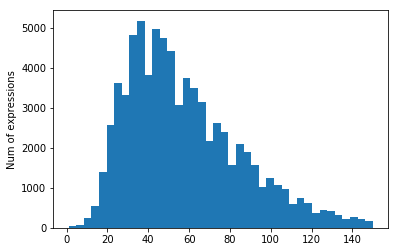

In [40]:
## Make a histogram of how long the sequences.
## Helps us decide on a cut off point

formula_file_path = "data/train.formulas.norm.txt"

formula_lengths = []

with open (formula_file_path, "r") as myfile:
    for idx, token_sequence in enumerate(myfile):
        tokens = token_sequence.split()
        formula_lengths.append(len(tokens))

%matplotlib inline
plt.hist(formula_lengths, normed=False, bins=40)
plt.ylabel('Num of expressions');

In [41]:
## Load and process data (takes a up to 10 minutes)

# max token length: 50
# max_image_size: (42, 200)

encoder_input_data, target_texts, token_vocabulary, decoder_lengths_data = load_data(dataset="train", 
                                                               max_token_length = 70,
                                                               max_image_size = (60, 270),
                                                               max_num_samples=10)

target_tokens = token_vocabulary

num_decoder_tokens = len(target_tokens)

max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

target_token_index = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items()) ## Will be used in the inference model

print("Maximum output sequence lenght: " + str(max_decoder_seq_length))
print("Examples of sequences: ")
print("Ex. 1: " + str(target_texts[0]))
print("Ex. 1: " + str(target_texts[1]) + "\n")

print("Number of examples: " + str(len(encoder_input_data)))


print("Number of tokens in our vocabulary: " + str(num_decoder_tokens))
print("5 example of tokens: " + str(target_tokens[0:5]) + "\n")

print("Example pairs (token, index) in dictionary: ")

for i, key in enumerate(target_token_index):
    print(key, target_token_index[key])
    if i > 10:
        break

_, image_h, image_w, _  = encoder_input_data.shape


downsampling images
[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
Getting max shape
Maximum output sequence lenght: 63
Examples of sequences: 
Ex. 1: **start** \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } } **end**
Ex. 1: **start** ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 , **end**

Number of examples: 10
Number of tokens in our vocabulary: 74
5 example of tokens: ['\\widetilde', '\\gamma', '_', '{', '\\mathrm']

Example pairs (token, index) in dictionary: 
('\\Phi', 66)
('\\frac', 16)
('\\widetilde', 0)
('\\gamma', 1)
('\\sqrt', 38)
('**end**', 73)
('\\partial', 54)
('B', 52)
('\\nu', 57)
('.', 53)
('\\alpha', 64)
('\\phi', 50)


In [42]:

#decoder_input_data, decoder_target_data = get_decoder_data_int_sequences(target_texts,
                                                                        #target_tokens,
                                                                        #num_decoder_tokens,
                                                                        #max_decoder_seq_length,
                                                                        #target_token_index)

In [43]:
# Get the data 



#num_samples = 128
#data_path = 'swe-eng/swe.txt'

# Vectorize the data.
#eng_texts = []

#eng_characters = set()

#decoder_lengths_data = []

#lines = open(data_path).read().split('\n')
#for line in lines[: min(num_samples, len(lines) - 1)]:
    #eng_text, swe_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    #eng_text = '\t' + eng_text + '\n'
    #eng_texts.append(eng_text)
    
    #decoder_lengths_data.append(len(eng_text))
    #for char in eng_text:
        #if char not in eng_characters:
            #eng_characters.add(char)
            
            

decoder_lengths_data = np.array(decoder_lengths_data)            
#random.shuffle(eng_texts)

In [44]:
# Create image from text


# Draw (Bitmap Font) Text to Image
#from PIL import Image, ImageDraw, ImageFont

#def reverseColor(r, g, b):
#    return (255 - r, 255 - g, 255 - b)
#def grayscaleColor(r, g, b):
    #a = (r + g + b) / 3
    #return (a, a, a)

In [45]:
#images = []
#from matplotlib import pyplot as plt

#for idx, eng_text in enumerate(eng_texts):
    #img = Image.new('L', (50, 20), 'white')
    #d = ImageDraw.Draw(img)
    #text = eng_text.strip('\n')
    #text = text.strip('\t')
    #d.text((4, 4), text, fill=(0))
    #images.append(np.asarray(img))
    #if idx < 16:
        #plt.imshow(np.asarray(img), cmap='gray')
        #plt.show()

In [46]:
## DATA: Images 

#encoder_input_data = np.array(images)

#encoder_input_data = encoder_input_data.reshape((encoder_input_data.shape[0], encoder_input_data.shape[1], encoder_input_data.shape[2], 1))

#encoder_input_data_non_normalized = encoder_input_data

#encoder_input_data = encoder_input_data.astype('float32')
#encoder_input_data = encoder_input_data / 255.0
#print(encoder_input_data.shape)

_, image_h, image_w, _ = encoder_input_data.shape

In [47]:
# DATA: Token sequences

token_vocabulary = sorted(list(token_vocabulary))
num_decoder_tokens = len(token_vocabulary)
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for outputs:', max_decoder_seq_length)

target_token_index = dict(
    [(char, i) for i, char in enumerate(token_vocabulary)])


reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items()) ## Will be used in the inference model


print(target_texts[0])
print(len(token_vocabulary[0]))

('Number of unique output tokens:', 74)
('Max sequence length for outputs:', 167)
**start** \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } } **end**
1


In [48]:
# 16
#'Number of unique output tokens:', 31)
#('Max sequence length for outputs:', 9)

# 17
#('Number of unique output tokens:', 32)
#('Max sequence length for outputs:', 10)

#18

#('Number of unique output tokens:', 34)
#('Max sequence length for outputs:', 10)
#	Run!

In [49]:

decoder_input_data = np.zeros(
        (len(target_texts), max_decoder_seq_length),
        dtype='float32')
decoder_target_data = np.zeros(
        (len(target_texts), max_decoder_seq_length),
        dtype='float32')
#decoder_target_data = np.zeros(
        #(len(eng_texts), max_decoder_seq_length, num_decoder_tokens),
        #dtype='float32')

num_other = 0


for i, target_text in enumerate(target_texts):
    for t, token in enumerate(target_text.split()):

        if token in target_token_index:
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = target_token_index[token]

            if t > 0:
                #decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1] = target_token_index[token]
                
        else:
            print(token)
            num_other = num_other + 1
            decoder_input_data[i, t] = target_token_index['other']

            if t > 0:
                #decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                
                decoder_target_data[i, t - 1] = target_token_index['other']


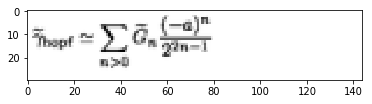

[[  4.  51.  36. ...,   0.   0.   0.]
 [  4.   0.  72. ...,   0.   0.   0.]
 [  4.  25.  53. ...,   0.   0.   0.]
 ..., 
 [  4.  22.  53. ...,   0.   0.   0.]
 [  4.  38.  17. ...,   0.   0.   0.]
 [  4.  72.  35. ...,   0.   0.   0.]]

[ 51.  36.  53.  72.  39.  72.  59.  65.  66.  57.  73.  73.  47.  49.  53.
  72.  64.  15.   9.  73.  51.  72.  19.  73.  53.  72.  64.  73.  72.  35.
  72.   0.   7.  54.   1.  52.  72.  64.  73.  73.  72.  11.  52.  72.  11.
  64.   7.  10.  73.  73.  73.   3.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   

In [50]:
#encoder_input_data.shape

plt.imshow(encoder_input_data[0].squeeze(), cmap='gray')
plt.show()


print(decoder_input_data)

print("")
print(decoder_target_data[0])


In [51]:
img_height = encoder_input_data[0].shape[0]
img_width = encoder_input_data[0].shape[1]

print(img_height)
print(img_width)



30
144


In [52]:
## Encoder

## One of Genthails's encoder implementations (on github not in paper)

img_height = encoder_input_data[0].shape[0]
img_width = encoder_input_data[0].shape[1]


img = tf.placeholder(tf.float32, [None, img_height, img_width, 1], name='img')


#batch_size = tf.placeholder(tf.float32, [1], name='batch_size')    
batch_size = tf.shape(img)[0]

# Conv + max pooling
out = tf.layers.conv2d(img, 64, 3, 1, "SAME", activation=tf.nn.relu)
out = tf.layers.max_pooling2d(out, 2, 2, "SAME")
# Conv + max pooling
out = tf.layers.conv2d(out, 128, 3, 1, "SAME", activation=tf.nn.relu)
   
out = tf.layers.batch_normalization(out)
  

# Conv
out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu) # regular conv -> id

# Conv + max pooling
out = tf.layers.conv2d(out, 256, 3, 1, "SAME", activation=tf.nn.relu)
out = tf.layers.max_pooling2d(out, (2, 2), (2, 2), "SAME")

#out = tf.layers.batch_normalization(out)


# Conv + max pooling
out = tf.layers.conv2d(out, 512, 3, 1, "SAME", activation=tf.nn.relu)
out = tf.layers.max_pooling2d(out, (2, 2), (2, 2), "SAME")



# Conv valid
out = tf.layers.conv2d(out, 512, 3, 1, "VALID", activation=tf.nn.relu, name="last_conv_layer") # conv
out = tf.layers.batch_normalization(out)

## Out is now a H'*W' encoding of the image

## We want to turn this into a sequence of vectors: (e1, e2 ... en)
H= out.shape[1]
W= out.shape[2] 

out = add_timing_signal_nd(out)
seq = tf.reshape(tensor=out, shape=[-1, int(H*W), 512])

# TODO: Add positional encodings

In [53]:

img_height = encoder_input_data[0].shape[0]
img_width = encoder_input_data[0].shape[1]

print(seq.shape)

l = seq.shape[1].value

print(H)
print(W)

print(img_height)
print(img_width)



(?, 32, 512)
2
16
30
144


In [54]:
# First state of the decoder consists of two vectors, the hidden state (h0) and the memory (c0).
# Usually the hidden state refers to [h0, c0]. So a little bit of overloading of hidden state (I think)
# This is how Genthail implements it

#tf.reset_default_graph()

num_units = 512


img_mean = tf.reduce_mean(seq, axis=1)

img_mean = tf.layers.batch_normalization(img_mean)

W = tf.get_variable("W", shape=[512, num_units])
b = tf.get_variable("b", shape=[num_units])
h0 = tf.tanh(tf.matmul(img_mean, W) + b)

W_ = tf.get_variable("W_", shape=[512, num_units])
b_ = tf.get_variable("b_", shape=[num_units])
c0 = tf.tanh(tf.matmul(img_mean, W_) + b_)




encoder_state = tf.contrib.rnn.LSTMStateTuple(c0, h0)





In [55]:
#attention_states: [batch_size, max_time, num_units]
attention_states = seq


attention_depth = num_units

# Create an attention mechanism
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    attention_depth, attention_states) ## Todo: Add sequence length. Check tutorial

In [56]:
print(c0.shape)
print(h0.shape)

#encoder_state.shape
max_decoder_seq_length
num_decoder_tokens

(?, 512)
(?, 512)


74

In [57]:
# Decoder: from seq2seq tutorial 



token_vocab_size = num_decoder_tokens # Number of tokens in our vocabulary

embedding_size = 80 # In Genthail's paper he says he has 80 embeddings which I believe corresponds to embedding_size

decoder_inputs = tf.placeholder(tf.int32, [None, max_decoder_seq_length], name='decoder_inputs')  # Supposed to be a sequence of numbers corresponding to the different tokens in the sentence

# Embedding of target tokens

# Embedding matrix 
embedding_decoder = tf.get_variable(
    "embedding_encoder", [token_vocab_size, embedding_size], tf.float32, initializer=tf.orthogonal_initializer) #  tf.float32 was default in the NMT tutorial

print("Token vocab size: ", token_vocab_size)
print("Embedding size: ", embedding_size)


# Look up embedding:
#   decoder_inputs: [max_time, batch_size]
#   decoder_emb_inp: [max_time, batch_size, embedding_size]
decoder_emb_inp = tf.nn.embedding_lookup(
    embedding_decoder, decoder_inputs)

print(decoder_emb_inp.shape)


('Token vocab size: ', 74)
('Embedding size: ', 80)
(?, 167, 80)


In [58]:

# Build RNN cell
decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)


attention = True
if attention:
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
        decoder_cell, attention_mechanism,
        attention_layer_size=512)

    ## Set initial state of decoder to zero (possible to use previous state)

    use_encoder_state = True
    if use_encoder_state:
        decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32).clone(cell_state=encoder_state)
    else:
        decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32)

else:
    decoder_initial_state = encoder_state

    
decoder_lengths = tf.placeholder(tf.int32, [None])

# Helper
helper = tf.contrib.seq2seq.TrainingHelper(
    decoder_emb_inp, decoder_lengths, time_major=False)

# Projection layer
projection_layer = layers_core.Dense(token_vocab_size, use_bias=False, name="output_projection")# Said layers_core before



In [59]:

# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)


In [60]:
print(tf.__version__)
decoder_initial_state

1.5.0-dev20171121


AttentionWrapperState(cell_state=LSTMStateTuple(c=<tf.Tensor 'Tanh_1:0' shape=(?, 512) dtype=float32>, h=<tf.Tensor 'Tanh:0' shape=(?, 512) dtype=float32>), attention=<tf.Tensor 'AttentionWrapperZeroState/zeros_1:0' shape=(?, 512) dtype=float32>, time=<tf.Tensor 'AttentionWrapperZeroState/zeros:0' shape=() dtype=int32>, alignments=<tf.Tensor 'AttentionWrapperZeroState/zeros_2:0' shape=(?, 32) dtype=float32>, alignment_history=())

In [61]:
# Dynamic decoding
outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, output_time_major=False)  ## Understand parameter Impute finished
logits = outputs.rnn_output
print(logits.shape)

(?, ?, 74)


In [62]:
target_weights = tf.placeholder(tf.float32, [None, None], name='target_weights')


# Supposed to be a sequence of numbers corresponding to the different tokens in the sentence
decoder_outputs = tf.placeholder(tf.int32, [None, None], name='decoder_outputs') 

max_gradient_norm = 10
#learning_rate = 0.001

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.0001
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           #5, 0.90, staircase=False)

boundaries = [30, 60, 90, 120, 150, 180, 210, 240]    
values = [0.00005, 0.00005, 0.00005, 0.00004, 0.00003, 0.00002, 0.00001, 0.00001, 0.00001]
    
learning_rate =  tf.train.piecewise_constant(global_step, boundaries, values, name=None)
    
    
# Loss function
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=decoder_outputs, logits=logits)
train_loss = tf.divide(tf.reduce_sum(crossent * target_weights), tf.cast(batch_size, tf.float32)) 


tf.summary.scalar('loss', train_loss)

# Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(train_loss, params)

#gradient_global_norm = tf.norm(gradients)


clipped_gradients, global_norm = tf.clip_by_global_norm(
    gradients, max_gradient_norm)

tf.summary.scalar('global_norm', global_norm)


# Optimization
optimizer = tf.train.AdamOptimizer(learning_rate)
update_step = optimizer.apply_gradients(
    zip(clipped_gradients, params), global_step=global_step)


In [63]:
param_names = [v.name for v in params]

gradient_names = [g.name for g in gradients]


gradient_norms = [tf.norm(gradient) for gradient in gradients]

#print(len(param_names))
#print(len(gradient_names))

grads = list(zip(gradients, params))



for grad, var in grads:
    tf.summary.histogram(var.name + '/gradient', grad)
# Merge all summaries into a single op
#merged_summary_op = tf.summary.merge_all()


for param in params:
    to_summary = tf.summary.histogram(param.name + '/weight', param)


INFO:tensorflow:Summary name conv2d/kernel:0/gradient is illegal; using conv2d/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d/bias:0/gradient is illegal; using conv2d/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0/gradient is illegal; using conv2d_1/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_1/bias:0/gradient is illegal; using conv2d_1/bias_0/gradient instead.
INFO:tensorflow:Summary name batch_normalization/gamma:0/gradient is illegal; using batch_normalization/gamma_0/gradient instead.
INFO:tensorflow:Summary name batch_normalization/beta:0/gradient is illegal; using batch_normalization/beta_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0/gradient is illegal; using conv2d_2/kernel_0/gradient instead.
INFO:tensorflow:Summary name conv2d_2/bias:0/gradient is illegal; using conv2d_2/bias_0/gradient instead.
INFO:tensorflow:Summary name conv2d_3/kernel:0/gradient is illegal; using conv2d_3/kernel_0/gradient i

In [64]:
# Creating the mask

decoder_mask_data = np.zeros(shape=(decoder_target_data.shape))
for idx, decoder_length in enumerate(decoder_lengths_data):
    decoder_mask_data[idx, :decoder_length] = np.ones((1, decoder_length))
    

In [65]:
decoder_mask_data

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.]])

In [66]:
# Check so all the input data has the same number of examples

assert (encoder_input_data.shape[0] == decoder_input_data.shape[0])

assert (decoder_input_data.shape[0] == decoder_target_data.shape[0])

assert (decoder_target_data.shape[0] == decoder_lengths_data.shape[0])

assert (decoder_lengths_data.shape[0] == decoder_mask_data.shape[0])


print("Encoder input data shape: ", encoder_input_data.shape)

print("Decoder input data shape: ", decoder_input_data.shape)

print("Decoder target data shape: ", decoder_target_data.shape)

print("Decoder lengths data shape: ", decoder_lengths_data.shape)

print("Decoder mask data shape: ", decoder_mask_data.shape)


assert (encoder_input_data[:12].shape[0] == decoder_input_data[:12].shape[0])

assert (decoder_input_data[:12].shape[0] == decoder_target_data[:12].shape[0])

assert (decoder_target_data[:12].shape[0] == decoder_lengths_data[:12].shape[0])

assert (decoder_lengths_data[:12].shape[0] == decoder_mask_data[:12].shape[0])


print("Encoder input data shape: ", encoder_input_data[:12].shape)

print("Decoder input data shape: ", decoder_input_data[:12].shape)

print("Decoder target data shape: ", decoder_target_data[:12].shape)

print("Decoder lengths data shape: ", decoder_lengths_data[:12].shape)

print("Decoder mask data shape: ", decoder_mask_data[:12].shape)


('Encoder input data shape: ', (10, 30, 144, 1))
('Decoder input data shape: ', (10, 167))
('Decoder target data shape: ', (10, 167))
('Decoder lengths data shape: ', (10,))
('Decoder mask data shape: ', (10, 167))
('Encoder input data shape: ', (10, 30, 144, 1))
('Decoder input data shape: ', (10, 167))
('Decoder target data shape: ', (10, 167))
('Decoder lengths data shape: ', (10,))
('Decoder mask data shape: ', (10, 167))


In [67]:


sess = tf.Session()

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('summaries/train/',
                                      sess.graph)

init = tf.global_variables_initializer()


sess.run(init)


In [ ]:
np.array([3]) 

array([3])

In [ ]:
## Minibatch implementation insipred by: https://wiseodd.github.io/techblog/2016/06/21/nn-sgd/

#for step in num_steps:

num_epochs = 100
mini_batch_size = 128
    
for epoch in range(num_epochs):

    for i in range(0, decoder_input_data.shape[0], mini_batch_size):

        max_length = max(decoder_lengths_data[i:i+mini_batch_size])

        input_data = {img: encoder_input_data[i:i+mini_batch_size],
                                        decoder_lengths: decoder_lengths_data[i:i+mini_batch_size],
                                         decoder_inputs: decoder_input_data[i:i+mini_batch_size],
                                          target_weights: decoder_mask_data[i:i+mini_batch_size, :max_length],
                                          decoder_outputs: decoder_target_data[i:i+mini_batch_size, :max_length]
                                         }

        output_tensors = [merged, update_step,train_loss, optimizer._lr, global_norm, gradient_norms, global_step]

        summary, _, loss, lr_rate, global_grad_norm, grad_norms, glob_step = sess.run(output_tensors, 
                               feed_dict=input_data)

        train_writer.add_summary(summary, glob_step)

        if i == 0:
            print("Epoch: ", epoch)

        #if glob_step % 5 == 0:
        print('Step %d: loss = %.2f' % (glob_step, loss))
        print("Learning rate: ", lr_rate)
        print("Global grad norm: ", global_grad_norm)

        
        
## Run the following in terminal to get up tensorboard: tensorboard --logdir=summaries/train        


('Epoch: ', 0)
Step 1: loss = 392.97
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 1905.6798)
('Epoch: ', 1)
Step 2: loss = 333.35
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 1694.339)
('Epoch: ', 2)
Step 3: loss = 284.59
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 1469.3441)
('Epoch: ', 3)
Step 4: loss = 245.29
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 1101.22)
('Epoch: ', 4)
Step 5: loss = 219.88
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 570.57764)
('Epoch: ', 5)
Step 6: loss = 211.56
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 276.49408)
('Epoch: ', 6)
Step 7: loss = 212.34
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 494.71344)
('Epoch: ', 7)
Step 8: loss = 212.41
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 604.15051)
('Epoch: ', 8)
Step 9: loss = 209.20
('Learning rate: ', 4.9999999e-05)
('Global grad norm: ', 614.67566)
('Epoch: ', 9)
Step 10: loss = 203.32
('Learning 

In [ ]:
#inference

tgt_sos_id = target_token_index['**start**'] # 4
tgt_eos_id = target_token_index['**end**'] # 3

# Helper
helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
    embedding_decoder,
    tf.fill([20], tgt_sos_id), tgt_eos_id)

maximum_iterations = 15 # Do max seq_length or find some other heuristic

# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)
# Dynamic decoding
outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
    decoder, maximum_iterations=maximum_iterations)
translations = outputs.sample_id



In [ ]:
trans = sess.run(translations, feed_dict = {img: encoder_input_data[:20]})

In [ ]:


trans




In [ ]:
decoder_target_data

In [ ]:
def get_token_seq(int_sequence):
    
    output_string = ""
    for value in int_sequence:
        output_string += reverse_target_token_index[value]
    
    return output_string

In [ ]:

for idx, seq in enumerate(decoder_target_data):
    
    print("Output: ")
    print(get_token_seq(trans[idx]))
    
    print("Ground truth: ")
    print(get_token_seq(seq))